In [1]:
import pandas as pd
import numpy as np
import re
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV



In [2]:
DIR_ = "D:/Drive/OneDrive/Documents/MIMIC"
DIR = "D:/Workspace/MIMIC_DATA/mimic-iii-clinical-database-1.4/"

In [3]:
adm_notes = pd.read_csv(DIR + "readmission.csv", low_memory=False)

# Natural Language

In [4]:
import string
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

In [5]:
def clean_text(texts):
    texts = texts.fillna(' ')
    texts = texts.str.replace('\n',' ')
    texts = texts.str.replace('\r',' ')

    table = str.maketrans('', '', string.punctuation + '0123456789')
    texts = [text.lower().translate(table) for text in texts]

    return texts

In [6]:
adm_notes['TEXT'] = clean_text(adm_notes['TEXT'])

In [7]:
stop_words = stopwords.words('english')
stop_words = stop_words + ['patient', 'date', 'admission', 'discharge', 'lastname', 'firstname', 'sex']

In [8]:
porter = PorterStemmer()

In [9]:
def tokenize_stem(text):
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [porter.stem(word) for word in words]
    return words

# Model
## Words, Train and Test

In [10]:
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, train_test_split

Repartition data

In [11]:
df_train, df_test = train_test_split(adm_notes, test_size=0.2)

Subsample non-readmitted patients to match size of readmitted ones

In [12]:
# Download necessary NLTK data
# nltk.download('punkt')

warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.feature_extraction.text')

# Balancing training dataset
rows_pos = df_train['READM_WITHIN_30'] == 1
df_train_pos = df_train.loc[rows_pos]
df_train_neg = df_train.loc[~rows_pos]
df_train = pd.concat([df_train_pos, df_train_neg.sample(n=len(df_train_pos))], axis=0)
df_train = df_train.sample(frac=1).reset_index(drop=True)  # shuffle the dataframe

In [13]:
# Balancing testing dataset
rows_pos = df_test['READM_WITHIN_30'] == 1
df_test_pos = df_test.loc[rows_pos]
df_test_neg = df_test.loc[~rows_pos]
df_test = pd.concat([df_test_pos, df_test_neg.sample(n=len(df_test_pos))], axis=0)
df_test = df_test.sample(frac=1).reset_index(drop=True)  # shuffle the dataframe

Sparse Matrix with word count

In [14]:
# Tokenize and stem function
def tokenize_stem(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Vectorization
vect = CountVectorizer(lowercase=True, max_features=1000, tokenizer=tokenize_stem)
vect.fit(df_train['TEXT'].values)

X_train_tf = vect.transform(df_train['TEXT'].values)
X_test_tf = vect.transform(df_test['TEXT'].values)

y_train = df_train['READM_WITHIN_30']
y_test = df_test['READM_WITHIN_30']


Proportion of 1 in test sample

In [15]:
sum(y_test == 1) / sum(y_test == 0)

1.0

## Logistic Regression

In [16]:
grid = {'C': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]}

model_log = GridSearchCV(LogisticRegression(penalty='l2', max_iter=5000), param_grid=grid)

model_log.fit(X_train_tf, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=5000),
             param_grid={'C': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]})

In [17]:
# model_log.fit(X_train_tf, y_train)

In [18]:
model_log.best_params_

{'C': 0.0005}

In [19]:
# Predicts probabilities, then rounds them to class predictions for train and test sets.
y_train_prob = model_log.predict_proba(X_train_tf)[:,1]
y_test_prob = model_log.predict_proba(X_test_tf)[:,1]

y_train_preds = np.round(y_train_prob)
y_test_preds = np.round(y_test_prob)

In [20]:
# Computes ROC curve, AUC, accuracy, precision, and recall for train and test sets.
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_prob)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [21]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precision\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7811622321546314 0.700535349716446
Accuracy	 0.7066582914572864 0.6443478260869565
Precission	 0.7348881485007139 0.666
Recall		 0.6465661641541038 0.5791304347826087


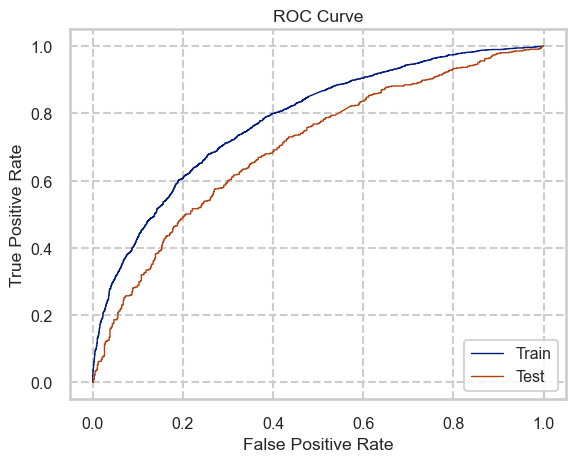

In [22]:
# Set the plotting style
sns.set('talk', 'whitegrid', 'dark', font_scale=0.7, rc={"lines.linewidth": 1, 'grid.linestyle': '--'})

# Plot the ROC curves
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Save the plot as PNG or PDF
plt.savefig('logistic_auroc.png')  # or 'logistic_auroc.pdf'


## Ridge Regression

In [23]:
grid={'alpha': np.arange(10000, 20000, 1000)}
model_ridge = GridSearchCV(Ridge(), param_grid=grid)

In [24]:
model_ridge.fit(X_train_tf, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': array([10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
       19000])})

In [25]:
model_ridge.best_params_

{'alpha': 16000}

In [26]:
y_train_reg = model_ridge.predict(X_train_tf)
y_test_reg = model_ridge.predict(X_test_tf)

y_train_preds = np.round(y_train_reg.clip(0, 1))
y_test_preds = np.round(y_test_reg.clip(0, 1))

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_reg)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_reg)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [28]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7655488497765208 0.7024862003780719
Accuracy	 0.6911641541038526 0.6521739130434783
Precission	 0.7206379893668439 0.6811594202898551
Recall		 0.6243718592964824 0.5721739130434783


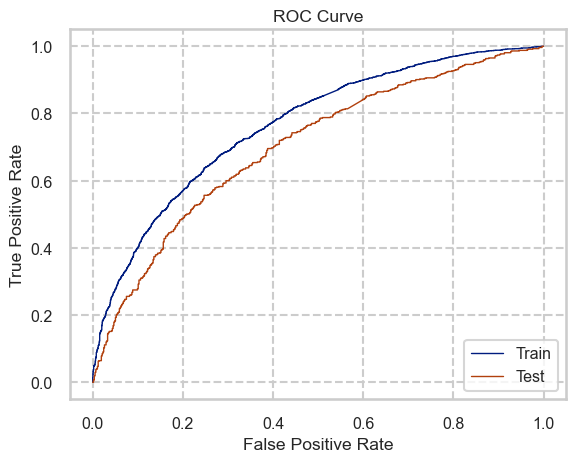

In [29]:
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('ridge_auroc.png')  # Change the file extension to .png

## Lasso Regression

In [30]:
# Define the parameter grid
grid = {'lasso__alpha': [0.1, 0.01, 0.001, 0.0001]}

# Create the Lasso regression model with increased max_iter and adjusted tolerance
lasso = Lasso(max_iter=10000, tol=1e-4)

# Create a pipeline that standardizes the data then applies Lasso regression
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # Set with_mean=False for sparse matrices
    ('lasso', lasso)
])

# Create the GridSearchCV object
model_lasso = GridSearchCV(estimator=pipeline, param_grid=grid, cv=5)


In [31]:
# Fit the model to your training data
model_lasso.fit(X_train_tf, y_train)

C:\Users\Dell\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:609: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6763268056744209, tolerance: 0.09552091075634668
  model = cd_fast.sparse_enet_coordinate_descent(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler',
                                        StandardScaler(with_mean=False)),
                                       ('lasso', Lasso(max_iter=10000))]),
             param_grid={'lasso__alpha': [0.1, 0.01, 0.001, 0.0001]})

In [32]:
# Print the best parameters and score
print("Best parameters found: ", model_lasso.best_params_)
print("Best cross-validation score: ", model_lasso.best_score_)

# Evaluate the model on the test set
test_score = model_lasso.score(X_test_tf, y_test)
print("Test set score: ", test_score)


Best parameters found:  {'lasso__alpha': 0.01}
Best cross-validation score:  0.09939002754681389
Test set score:  0.10972664342848737


In [33]:
y_train_reg = model_lasso.predict(X_train_tf)
y_test_reg = model_lasso.predict(X_test_tf)

y_train_preds = np.round(y_train_reg.clip(0, 1))
y_test_preds = np.round(y_test_reg.clip(0, 1))

In [34]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_prob)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [35]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7811622321546314 0.700535349716446
Accuracy	 0.6733668341708543 0.6426086956521739
Precission	 0.705765407554672 0.6722689075630253
Recall		 0.5946398659966499 0.5565217391304348


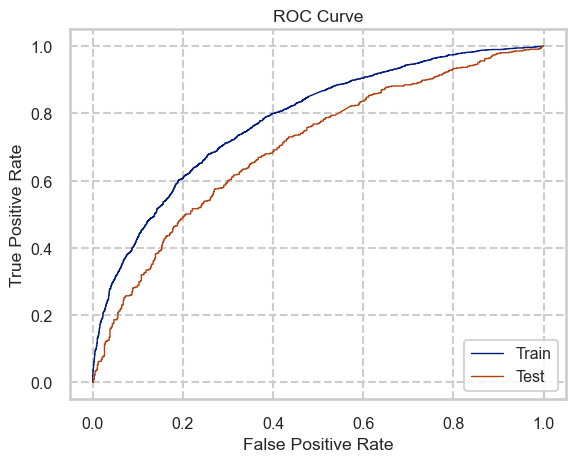

In [36]:
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('lasso_auroc.png')

## ElasticNet

In [37]:
np.arange(0.1, 1.0, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [38]:
# Define the parameter grid
grid = {
    "alpha": [0.01, 0.1, 1, 10, 100],
    "l1_ratio": np.arange(0.1, 1.0, 0.1)
}

# Create the ElasticNet model with increased max_iter and decreased tolerance
elastic_net = ElasticNet(max_iter=100000, tol=1e-5)

# Create the GridSearchCV object
model_enet = GridSearchCV(estimator=elastic_net, param_grid=grid, cv=5)

In [39]:
# Fit the model to your training data (replace X_train_tf and y_train with your actual training data)
model_enet.fit(X_train_tf, y_train)

# Print the best parameters and score
print("Best parameters found: ", model_enet.best_params_)
print("Best cross-validation score: ", model_enet.best_score_)

# Evaluate the model on the test set (replace X_test_tf and y_test with your actual test data)
test_score = model_enet.score(X_test_tf, y_test)
print("Test set score: ", test_score)


Best parameters found:  {'alpha': 0.1, 'l1_ratio': 0.1}
Best cross-validation score:  0.09488925525869762
Test set score:  0.10699641347168165


In [40]:
y_train_prob = model_enet.predict(X_train_tf)
y_test_prob = model_enet.predict(X_test_tf)

y_train_preds = np.round(y_train_prob)
y_test_preds = np.round(y_test_prob)

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_prob)
fprt, tprt, thresholds = metrics.roc_curve(y_test, y_test_prob)

auc_train = metrics.auc(fpr, tpr)
auc_test = metrics.auc(fprt, tprt)

acc_train = metrics.accuracy_score(y_train, y_train_preds)
acc_test = metrics.accuracy_score(y_test, y_test_preds)

prec_train = metrics.precision_score(y_train, y_train_preds)
prec_test = metrics.precision_score(y_test, y_test_preds)

rec_train = metrics.recall_score(y_train, y_train_preds)
rec_test = metrics.recall_score(y_test, y_test_preds)

In [42]:
print('Set\t\t', 'Train\t\t', '   Test')
print('AUC\t\t', auc_train, auc_test)
print('Accuracy\t', acc_train, acc_test)
print('Precission\t', prec_train, prec_test)
print('Recall\t\t', rec_train, rec_test)

Set		 Train		    Test
AUC		 0.7496159608764089 0.6990865784499056
Accuracy	 0.6790201005025126 0.6452173913043479
Precission	 0.7074235807860262 0.6693711967545639
Recall		 0.6105527638190955 0.5739130434782609


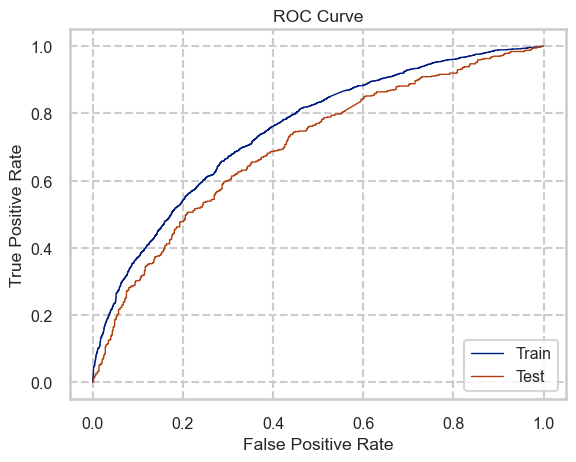

In [43]:
plt.plot(fpr, tpr, label='Train')
plt.plot(fprt, tprt, label='Test')
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.savefig('elastic_auroc.png')